In [ ]:
import os
import sys
import numpy as np

# Add the path to the custom library to the system path
sys.path.append('..')

# Import custom modules
from src import Tensor
from src.core.utils import data_analysis, context_manager
from src.architectures.transformer import Tokenizer, Transformer, DataLoader

### Constants and hyperparameters

In [3]:
# Constants
dataset_path = os.path.join(os.getcwd(), 'dataset', 'divina_commedia.txt')
tokenizer_path = os.path.join(os.getcwd(), 'checkpoints', 'tokenizer.json')
model_path = os.path.join(os.getcwd(), 'checkpoints', 'language_model.npz')

In [4]:
# Hyperparameters
dropout = 0.2 # The dropout rate
train_val_split = 0.9 # 90% of the data will be used for training, 10% for validation
batch_size = 32 # The number of samples to use for each batch
grad_accumulation_steps = 1 # The number of steps to accumulate gradients before updating the model
sequence_length = 256 # The size of the sequence length (the context window)
learning_rate = 1e-3 # The learning rate for the optimizer
training_steps = 300 # The number of steps to train the model for
n_embed = 384 # The size of the token embeddings (the dimensionality of the embeddings)
eval_iters = 1 # The number of iterations to evaluate the model
n_attention_heads = 6 # The number of attention heads in the multi-head attention mechanism
n_decoder_blocks = 6 # The number of transformer'decoder blocks in the model

### Data loading

In [5]:
def load_txt_file(path: str) -> str:
    """
    Load a text file from the specified path.
    
    Parameters:
    - path (str): The path to the text file.
    
    Returns:
    - str: The contents of the text file.
    """
    
    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f'The file "{path}" does not exist.')
    
    # Read the file
    with open(path, 'r', encoding='utf-8') as file:
        return file.read()

In [6]:
# Instantiate the tokenizer
tokenizer = Tokenizer()

# Load the state of the tokenizer
tokenizer.load(tokenizer_path)

# Extract the vocabulary size
vocab_size = tokenizer.get_vocab_size()

In [7]:
# Load the text file
text = load_txt_file(dataset_path)

# Encode the text using the tokenizer
encoded_text = tokenizer.encode(text)

# Convert the data to a tensor
data = Tensor(np.array(encoded_text), dtype=np.int32)

In [8]:
# Instantiate the data loader
data_loader = DataLoader(
    data = data, 
    train_val_split = train_val_split
)

### Building the model

In [9]:
# Create the language model
language_model = Transformer(
    name = "Language Model",
    vocab_size = vocab_size,
    n_embed = n_embed,
    n_attention_heads = n_attention_heads,
    sequence_length = sequence_length,
    n_decoder_blocks = n_decoder_blocks,
    dropout = dropout
)

### Initializing the model

In [10]:
# Check if the model is already trained
if os.path.exists(model_path):
    # Load the model to continue training
    print("Loading the model from the checkpoint...")
    language_model.load(model_path)
    print("Model loaded successfully.")

Loading the model from the checkpoint...
Model loaded successfully.


In [11]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    language_model.eval()
    
    # Get a batch of data
    x, _ = data_loader.get_batch(
        batch_size = batch_size,
        sequence_length = sequence_length
    )
    
    # Call the model with a batch of data to initialize it
    language_model(x)

In [12]:
# Display the model summary in tree format.
# This is useful since the whole model is composed of submodules,
# therefore, the model summary will be displayed recursively
language_model.summary(recursive=True)

Language Model (Transformer) [output_shape=(32, 256, 1024), params=11526400]
└── language_model.decoder (Decoder) [output_shape=(32, 256, 1024), params=11526400]
    ├── decoder.embedding (Embedding) [output_shape=(32, 256, 384), params=393216]
    ├── decoder.positional_embedding (Embedding) [output_shape=(256, 384), params=98304]
    ├── decoder.decoder_blocks[0].decoder_block (DecoderBlock) [output_shape=(32, 256, 384), params=1773312]
    │   ├── decoder_block.layer_norm_1 (LayerNormalization) [output_shape=(32, 256, 384), params=768]
    │   ├── decoder_block.mlp (MLP) [output_shape=(32, 256, 384), params=1181568]
    │   │   ├── mlp.dropout (Dropout) [output_shape=(32, 256, 384), params=0]
    │   │   ├── decoder_block.mlp.input_dense (Dense) [output_shape=(32, 256, 1536), params=591360]
    │   │   └── decoder_block.mlp.output_dense (Dense) [output_shape=(32, 256, 384), params=590208]
    │   ├── decoder_block.layer_norm_2 (LayerNormalization) [output_shape=(32, 256, 384), param

### Training the model

In [13]:
# Train the model
history = language_model.fit(
    data_loader = data_loader,
    steps = training_steps,
    lr = learning_rate,
    batch_size = batch_size,
    eval_iters = eval_iters,
    grad_accumulation_steps = grad_accumulation_steps,
)

Step 1/300 | 217 tensors in memory | 4299.82 ms/step - Train Loss: 3.0958 | Validation loss: 3.1404
Step 2/300 | 222 tensors in memory | 4286.74 ms/step - Train Loss: 3.4926 | Validation loss: 3.4244
Step 3/300 | 222 tensors in memory | 4311.43 ms/step - Train Loss: 3.1923 | Validation loss: 3.2290
Step 4/300 | 222 tensors in memory | 4267.52 ms/step - Train Loss: 3.2104 | Validation loss: 3.2410
Step 5/300 | 222 tensors in memory | 4245.93 ms/step - Train Loss: 3.1545 | Validation loss: 3.2130
Step 6/300 | 222 tensors in memory | 4267.75 ms/step - Train Loss: 3.1558 | Validation loss: 3.2020
Step 7/300 | 222 tensors in memory | 4211.58 ms/step - Train Loss: 3.1902 | Validation loss: 3.1898
Step 8/300 | 222 tensors in memory | 4158.03 ms/step - Train Loss: 3.1648 | Validation loss: 3.1788
Step 9/300 | 222 tensors in memory | 4114.01 ms/step - Train Loss: 3.1510 | Validation loss: 3.1594
Step 10/300 | 222 tensors in memory | 4135.16 ms/step - Train Loss: 3.1291 | Validation loss: 3.1691

In [14]:
# Save the model
language_model.save(model_path)

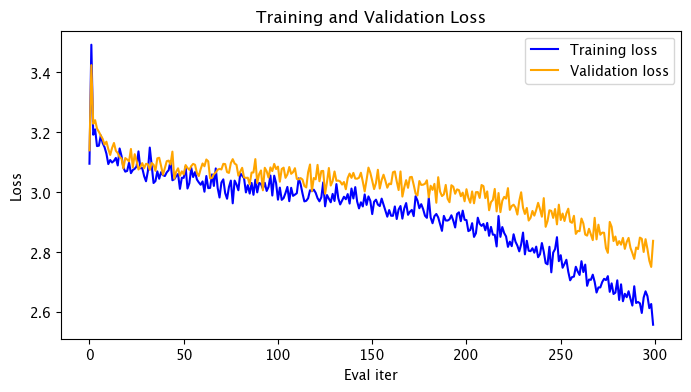

In [15]:
# Plot the training and validation loss
data_analysis.plot_history(history["loss"].data, history["val_loss"].data, "Training and Validation Loss", "Eval iter", "Loss")

### Inference

In [16]:
# Generate some text context from the trained model
context = Tensor(np.zeros((1, 1), dtype=np.int32))

# Iterate over the tokens generated by the transformer
for token in language_model.generate(context, max_new_tokens=200, stream=True):
    # Decode the token
    decoded_token = tokenizer.decode([token.data.squeeze().tolist()])

    # Print the decoded token
    print(decoded_token, end='', flush=True)

e era;
a d'alto a cangi secondo da tutti alcuna di sciolta,
quand'alto fui dismostrar passo.
Tu fuor tra di compagni
per questo Puovata il messo;
e l'altro di noi si aldica e sentieri e di Mari.
Facentr'avessebbea verelli e a Conte, e tardindio,
che l'altro era parlato non pacestia nostro
d'era che nel disio ser gognito,
per torn